In [1]:
import source_synphot.passband
import source_synphot.io
import source_synphot.source
import astropy.table as at
from collections import OrderedDict
import pysynphot as S
import matplotlib.pyplot as plt
import numpy as np
from scipy import interpolate
%matplotlib notebook

#from zp_fit import *
from scipy.optimize import minimize
from astropy.stats import sigma_clip
import pandas as pd
import warnings
#warnings.filterwarnings("ignore")
def myround(x, prec=2, base=.5):
    return round(base * round(float(x)/base),prec)

In [2]:
models = at.Table.read('ckmodels.txt',format='ascii')
logZ = 0.
model_sed_names = []
temp = []
for s in models:
    teff = max(3500.,s['teff'])
    logg = myround(s['logg'])
    # the models with logg < 1 are just padded with 0s
    if logg >= 1:
        temp.append(teff)
        modstring = 'ckmod{:.0f}_{:.1f}_{:.2f}'.format(teff,logZ, logg)
        model_sed_names.append(modstring)
model_sed = source_synphot.source.load_source(model_sed_names)

/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod44852_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod42857_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod40862_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod39865_0.0_4.00 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod40300_0.0_3.50 not loaded
  warnings.warn(message, RuntimeWarning)
/Users/ryanr/Documents/PhD/coding/source_synphot/source_synphot/source.py:50: RuntimeWarning: Source ckmod39000_0.0_3.00 not loaded
  w

In [3]:
passbands = at.Table.read('source_synphot/passbands/pbzptmag.txt',format='ascii')
pbnames = [x['obsmode'] for x in passbands if x['passband'].startswith("TESS")]
pbnames += [x['obsmode'] for x in passbands if x['passband'].startswith("PS1")]
model_mags = 0.
model = 'AB'
pbs = source_synphot.passband.load_pbs(pbnames, model_mags, model)
pbnames = pbs.keys()

In [4]:
color1 = 'ps1g_ps1r'
color2 = 'ps1r_tess'
color3 = 'ps1g_tess'
color4 = 'tess_ps1i'
color5 = 'tess_ps1z'
col1 = []
col2 = []
col3 = []
col4 = []
col5 = []
col6 = []
# construct color-color vectors
for modelname in model_sed:
    model= model_sed[modelname]
    model = S.ArraySpectrum(model.wave, model.flux, name=modelname)
    g, r = color1.split('_')
    pbg, zpg = pbs[g]
    pbr, zpr = pbs[r]
    i = 'ps1i'
    z = 'ps1z'
    t = 'tess'
    pbi, zpi = pbs[i]
    pbz, zpz = pbs[z]
    pbt, zpt = pbs[t]
    thiscol1 = source_synphot.passband.syncolor(model, pbg, pbr, zpg, zpr)
    thiscol2 = source_synphot.passband.syncolor(model, pbg, pbt, zpg, zpt)
    thiscol3 = source_synphot.passband.syncolor(model, pbr, pbt, zpr, zpt)
    thiscol4 = source_synphot.passband.syncolor(model, pbt, pbi, zpt, zpi)
    thiscol5 = source_synphot.passband.syncolor(model, pbt, pbz, zpt, zpz)
    #thiscol6 = source_synphot.passband.syncolor(model, pbi, pbz, zpi, zpz)

    col1.append(thiscol1)
    col2.append(thiscol2)
    col3.append(thiscol3)
    col4.append(thiscol4)
    col5.append(thiscol5)
    #col6.append(thiscol6)
col1 = np.array(col1)
col2 = np.array(col2)
col3 = np.array(col3)
col4 = np.array(col4)
col5 = np.array(col5)
#col6 = np.array(col6)
# select only useful objects
good = ~np.isnan(col1)* ~np.isnan(col2)* ~np.isnan(col3)* ~np.isnan(col4)* ~np.isnan(col5)#* ~np.isnan(col6)
good = np.array(good)

-43.46142641608394 -42.98333592355688
-43.46142641608394 -42.59288150844757
-42.98333592355688 -42.59288150844757
-42.59288150844757 -42.60947897282194
-42.59288150844757 -42.30620538941916
-43.42811488150393 -42.951515875740036
-43.42811488150393 -42.56134065631042
-42.951515875740036 -42.56134065631042
-42.56134065631042 -42.57774416616112
-42.56134065631042 -42.27580812278789
-43.39254864242051 -42.91768135862316
-43.39254864242051 -42.52748194878339
-42.91768135862316 -42.52748194878339
-42.52748194878339 -42.543554018019584
-42.52748194878339 -42.24330276234709
-43.353785389445065 -42.880558352350945
-43.353785389445065 -42.48982132892896
-42.880558352350945 -42.48982132892896
-42.48982132892896 -42.505428421999966
-42.48982132892896 -42.206909080304385
-43.31022613671858 -42.83852207668186
-43.31022613671858 -42.44677360678013
-42.83852207668186 -42.44677360678013
-42.44677360678013 -42.46180740425197
-42.44677360678013 -42.16510897892403
-43.26048351414385 -42.79024698323816
-43

-38.553989060739994 -38.590614338389074
-37.041836871944284 -37.75362225063052
-37.041836871944284 -37.98257163161324
-37.75362225063052 -37.98257163161324
-37.98257163161324 -37.98193650475916
-37.98257163161324 -38.070770137237176
-36.30623009893371 -37.187886170716304
-36.30623009893371 -37.51475865230017
-37.187886170716304 -37.51475865230017
-37.51475865230017 -37.49589104696214
-37.51475865230017 -37.64850688626433


<IPython.core.display.Javascript object>


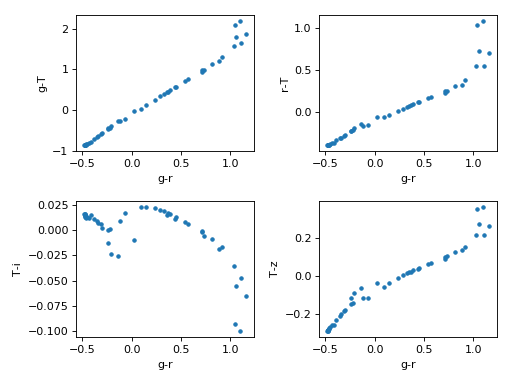

In [5]:
plt.figure()
plt.subplot(2,2,1)
plt.plot(col1[good],col2[good],'.')
plt.ylabel('g-T')
plt.xlabel('g-r')
plt.subplot(2,2,2)
plt.plot(col1[good],col3[good],'.')
plt.ylabel('r-T')
plt.xlabel('g-r')
plt.subplot(2,2,3)
plt.plot(col1[good],col4[good],'.')
plt.ylabel('T-i')
plt.xlabel('g-r')
plt.subplot(2,2,4)
plt.plot(col1[good],col5[good],'.')
plt.ylabel('T-z')
plt.xlabel('g-r')
plt.tight_layout()